In [480]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import geopandas as gpd
from cartopy import config
from cartopy.feature import BORDERS
import cartopy.crs as ccrs
import urllib.request
import json 
from collections import defaultdict

In [10]:
venues_data = pd.read_csv('venues.csv')
calendar_data = pd.read_csv('calendar.csv')
demo_data = pd.read_csv('demographics.csv')
econ_state_data = pd.read_csv('econ_state.csv')
listings_data = pd.read_csv('listings.csv')
real_estate_data = pd.read_csv('real_estate.csv')

In [479]:
demo_data

,zipcode,population,5_years_or_less,5-9_years,10-14_years,15-19_years,20-24_years,25-34_years,35-44_years,45-54_years,...,"$10,000-$14,999","$15,000-$24,999","$25,000-$34,999","$35,000-$49,999","$50,000-$64,999","$65,000-$74,999","$75,000-$99,999","$100,000_or_more",median_household_income,mean_household_income
0,601,17982,17982,1006,1080,1342,1352,1321,2253,2149,...,48.1,12,12.8,8.6,8.7,6.2,1.4,16.3,10816,20349
1,602,40260,40260,2006,2440,2421,2953,2865,5124,5139,...,31.4,16.3,17.9,12.2,10.6,7.7,2.9,21.2,16079,23282
2,603,52408,52408,2664,3177,3351,3685,3585,6473,6775,...,31,14.9,17.5,11.7,10.8,8.7,2.4,21.9,16804,26820
3,606,6331,6331,347,331,461,474,469,707,933,...,45.3,10.2,20,11.7,11,1.8,0,12.8,12512,15730
4,610,28328,28328,1438,1490,2044,2122,1985,3358,3778,...,26.9,14.8,23.7,15.2,9.3,7.5,1.6,18.4,17475,23360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33115,99923,13,13,0,0,0,0,0,0,0,...,0,46.2,53.8,0,0,0,0,0,-,N
33116,99925,826,826,65,50,47,36,60,86,82,...,7.1,6.2,21.2,11.1,12.6,17.5,9.5,39.6,38594,52706
33117,99926,1711,1711,161,124,140,113,107,224,182,...,5.5,1.9,14.1,11.1,16.8,14.5,12,43.3,51071,71580
33118,99927,123,123,0,0,0,0,0,0,32,...,28.2,0,23.1,15.4,25.6,0,0,25.6,19861,35617


In [105]:
#Note that listings, real_estate, demo_data contain zip code data
#listings may not be worth it??
zip_codes = gpd.read_file('tl_2019_us_zcta510/tl_2019_us_zcta510.shp')
counties = gpd.read_file('cb_2018_us_county_20m/cb_2018_us_county_20m.shp')
state_fips = pd.read_csv('state_fips.csv')[['Name', 'Postal Code', 'FIPS']]
counties['FIPS'] = counties['STATEFP'].astype('int32')

In [107]:
counties = counties.merge(state_fips, on='FIPS', how='left')
real_estate_data.columns

Index(['type', 'zipcode', 'city', 'state', 'metro', 'county', 'size_rank',
       '1996-04', '1996-05', '1996-06',
       ...
       '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02',
       '2017-03', '2017-04', '2017-05', '2017-06'],
      dtype='object', length=262)

In [143]:
real_estate_counties = counties.merge(real_estate_data, left_on=['NAME', 'Postal Code'], right_on=['county', 'state'])
real_estate_counties['2014-09']

0          841
1          838
2          842
3          886
4          960
         ...  
28194    91000
28195    85500
28196    92500
28197    89400
28198    86800
Name: 2014-09, Length: 28199, dtype: int64

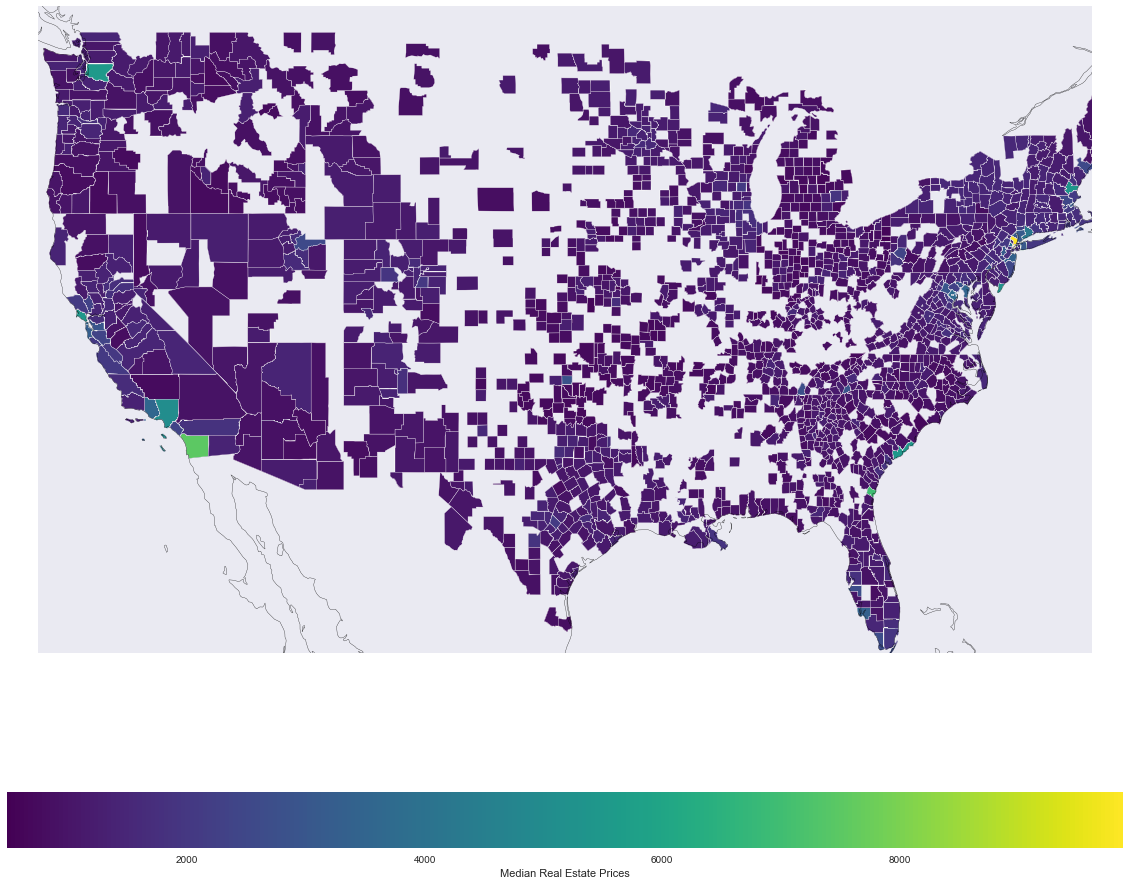

In [172]:
month_year = '2012-09'
fig1, ax1 = plt.subplots(figsize=(20,17))
ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1.coastlines()
#demo_zip.plot(column='median_household_income', cmap='viridis', ax=ax1, legend=True)
real_estate_counties.query('`{}` < 10000'.format(month_year)).plot(column=month_year, cmap='viridis', ax=ax1, legend=True, legend_kwds={'label': 'Median Real Estate Prices', "orientation": "horizontal"})#column='median_household_income', cmap='viridis', ax=ax1, legend=True)
ax1.set_xlim((-125,-70))
ax1.set_ylim((25,50))
plt.savefig('housing_prices_heatmap_{}.png'.format(month_year))

In [48]:
zip_codes.head()
zip_codes['zipcode'] = zip_codes['ZCTA5CE10'].astype('int32')
zip_codes = gpd.read_file('tl_2019_us_zcta510/tl_2019_us_zcta510.shp')

In [160]:
#demo_zip = zip_codes.merge(demo_data, on='zipcode')#, how='right')
#estate_zip = zip_codes.merge(real_estate_data.groupby('zipcode').mean(), on='zipcode')
listings_data.groupby('city').count().rsub(listings_data.groupby('city').size(), axis=0)['weekly_price'].sort_values().tail(20)

city
culver city          187
lakewood             191
burbank              195
arcadia              212
redondo beach        235
lawndale             263
venice               290
rowland heights      296
malibu               318
Asheville            325
beverly hills        391
playa del rey        443
south pasadena       619
santa monica         764
west hollywood       781
hermosa beach        975
nashville           2270
New Orleans         4530
austin              7770
los angeles        14863
Name: weekly_price, dtype: int64

In [87]:
#Create aggregated datasets for listings etc. 
print(listings_data)
#agg_listings = listings_data.groupby('zipcode').mean()
#print(listings_data['zipcode'])

       accommodates                                          amenities  \
0               2.0  {"Wireless Internet","Air Conditioning",Kitche...   
1               4.0  {TV,"Cable TV",Internet,"Wireless Internet","A...   
2               1.0  {TV,"Wireless Internet","Air Conditioning",Kit...   
3               6.0  {Internet,"Wireless Internet","Air Conditionin...   
4               6.0  {Internet,"Wireless Internet","Free Parking on...   
...             ...                                                ...   
50316           2.0  {TV,"Cable TV","Wireless Internet","Pets live ...   
50317           2.0  {"Wireless Internet",Kitchen,"Free parking on ...   
50318          10.0  {TV,"Wireless Internet","Air conditioning",Kit...   
50319           4.0  {TV,Internet,"Wireless Internet","Air conditio...   
50320           8.0  {TV,"Wireless Internet","Air conditioning",Kit...   

       availability_30  bathrooms  bed_type  bedrooms  beds  \
0                    0        1.0  Real Bed     

Index(['ZCTA5CE10', 'GEOID10', 'CLASSFP10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry', 'zipcode',
       'population', '5_years_or_less', '5-9_years', '10-14_years',
       '15-19_years', '20-24_years', '25-34_years', '35-44_years',
       '45-54_years', '55-59_years', '60-64_years', '65-74_years',
       '75-84_years', '85_years_or_more', 'households', '$9,999_or_less',
       '$10,000-$14,999', '$15,000-$24,999', '$25,000-$34,999',
       '$35,000-$49,999', '$50,000-$64,999', '$65,000-$74,999',
       '$75,000-$99,999', '$100,000_or_more', 'median_household_income',
       'mean_household_income'],
      dtype='object')


(25.0, 50.0)

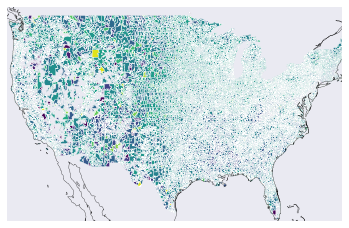

In [162]:
fig1, ax1 = plt.subplots()
ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1.coastlines()
#demo_zip.plot(column='median_household_income', cmap='viridis', ax=ax1, legend=True)
print(demo_zip.columns)
demo_zip.plot(column='$100,000_or_more', cmap='viridis', ax=ax1)#column='median_household_income', cmap='viridis', ax=ax1, legend=True)
ax1.set_xlim((-125,-70))
ax1.set_ylim((25,50))

In [ ]:
fig1, ax1 = plt.subplots()
ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1.coastlines()
#demo_zip.plot(column='median_household_income', cmap='viridis', ax=ax1, legend=True)
estate.plot(column='median_household_income', cmap='viridis', ax=ax1, legend=True)#column='median_household_income', cmap='viridis', ax=ax1, legend=True)
ax1.set_xlim((-125,-70))
ax1.set_ylim((25,50))

In [184]:
#tidy the real estate data
real_estate_tidy = real_estate_data.melt(id_vars=['type', 'zipcode', 'city', 'state', 'metro', 'county', 'size_rank'],var_name='date', value_name='monthly_avg_price')

In [185]:
real_estate_tidy.head()

,type,zipcode,city,state,metro,county,size_rank,date,monthly_avg_price
0,ZHVI,10025,New York,NY,New York,New York,1,1996-04,NaN
1,ZHVI,60657,Chicago,IL,Chicago,Cook,2,1996-04,146700.0
2,ZHVI,60614,Chicago,IL,Chicago,Cook,3,1996-04,198000.0
3,ZHVI,79936,El Paso,TX,El Paso,El Paso,4,1996-04,70800.0
4,ZHVI,60640,Chicago,IL,Chicago,Cook,5,1996-04,102300.0


In [188]:
#tidy the demographic data into two 
print(demo_data.columns)
demo_data_tidy = demo_data.melt(id_vars=['zipcode', 'population', 'households', 'median_household_income', 'mean_household_income'], var_name = 'ranges', value_name = 'counts')

Index(['zipcode', 'population', '5_years_or_less', '5-9_years', '10-14_years',
       '15-19_years', '20-24_years', '25-34_years', '35-44_years',
       '45-54_years', '55-59_years', '60-64_years', '65-74_years',
       '75-84_years', '85_years_or_more', 'households', '$9,999_or_less',
       '$10,000-$14,999', '$15,000-$24,999', '$25,000-$34,999',
       '$35,000-$49,999', '$50,000-$64,999', '$65,000-$74,999',
       '$75,000-$99,999', '$100,000_or_more', 'median_household_income',
       'mean_household_income'],
      dtype='object')


In [191]:
demo_data_tidy.head()
demo_data_tidy['range_type'] = demo_data_tidy['ranges'].apply(lambda x: 'income_range' if x[0] == '$' else 'age_range')

440131      $9,999_or_less
473251     $10,000-$14,999
506371     $15,000-$24,999
539491     $25,000-$34,999
572611     $35,000-$49,999
605731     $50,000-$64,999
638851     $65,000-$74,999
671971     $75,000-$99,999
705091    $100,000_or_more
Name: ranges, dtype: object
440131    2682
473251     7.9
506371     6.4
539491    16.9
572611     9.2
605731    10.9
638851    12.2
671971     8.2
705091    31.3
Name: counts, dtype: object


<BarContainer object of 9 artists>

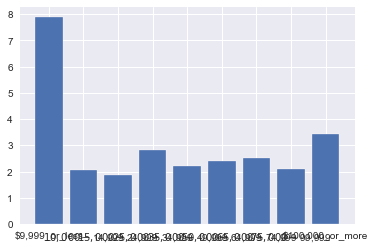

In [229]:
temp_demo = demo_data_tidy.query('zipcode == 30002 & range_type == "income_range"')
print(temp_demo['ranges'])
print(temp_demo['counts'])
plt.bar(height=np.log(temp_demo['counts'].astype('float64')), x=temp_demo['ranges'])
#demo_data_tidy

    objectid         po_name    shape_star     shape_stle    zip  \
0        1.0         MADISON  5.965534e+08  178783.024889  37115   
1       33.0       NASHVILLE  1.203346e+08   93532.890730  37203   
2        9.0       NASHVILLE  2.006648e+08   93180.292250  37204   
3       18.0        FRANKLIN  4.696961e+07   28995.828321  37064   
4       57.0       NASHVILLE  3.150782e+05    2247.452149  37246   
5       23.0          PEGRAM  1.900365e+06    7047.826758  37143   
6       42.0         JOELTON  5.652261e+04    2319.807424  37080   
7       54.0       NASHVILLE  7.392009e+07   58759.243654  37212   
8        7.0     NOLENSVILLE  7.470727e+07   69742.560630  37135   
9       31.0       BRENTWOOD  3.045961e+05    3116.432715  37027   
10      30.0       BRENTWOOD  2.446098e+07   30401.649619  37027   
11      45.0  GOODLETTSVILLE  3.337338e+06    9724.506184  37072   
12      29.0       BRENTWOOD  5.803064e+03     524.236416  37027   
13      28.0       BRENTWOOD  5.533841e+05    30

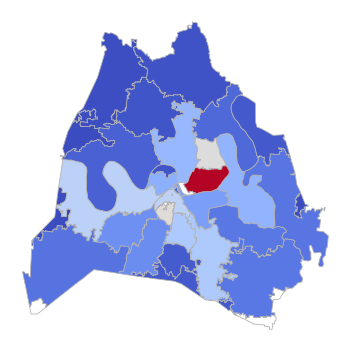

In [427]:
#Here's a calculation of how many AirBnb houses lie in a particular zip code
#first, merge aggregated zipcodes with Austin (or whatever city) shapefile
#lol, before we go too far we should double check LA to see if the methodology is correct
listings_counts = listings_data.groupby('zipcode').count()['city']
#print(listings_data)
city_zipcodes = gpd.read_file('nashville/geo_export_ce95ea06-82ce-4673-82c7-c568df5a3eec.shp')
#city_zipcodes = gpd.read_file('la/b982f3c3-ffe6-4e4a-b8e6-2bd1eb2c70642020328-1-26h3sc.00ox.shp')
print(city_zipcodes)
city_zip_counts = city_zipcodes.merge(listings_counts, how='left', left_on='zip', right_index=True)
#print(city_zip_counts['city'])

#then plot graph as shown below
data = city_zip_counts
na = data[pd.isna(data['city'])]
#data
fig, ax = plt.subplots(1, figsize=(5,5))
ax.axis('off')
na.plot(color='white', linewidth=0.8, ax=ax, edgecolor='0.7')
data.plot(column='city', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.7')
fig.tight_layout()
city = 'la'
feature = 'listings'
fig.savefig(city+'_'+feature+'.png', format='png', dpi=1000)
plt.show()

In [474]:
#Now, let's see if we can try to fetch gentrification data and retrieve a similar plot afterwards...
demo_millenial = demo_data_tidy.query('ranges == "25-34_years" & population > 0')
#print(demo_data_tidy.tail()) 
#four components of score: age proportion growth, education level growth, median income growth, median gross rent growth, 
#honestly I think comparing 2011 to 2019 levels should be fine, this is recent data after all...
#year = '2011'

#State fips number
state_no = '47'
data_dicts = []
for ind, year in enumerate(['2011', '2017']):
    data_dict = defaultdict(lambda: [np.nan, np.nan, np.nan, np.nan])
    #median household income
    income_url = 'https://api.census.gov/data/{}/acs/acs5/subject?get=NAME,S1901_C01_012E&for=zip%20code%20tabulation%20area:*&in=state:{}'.format(year, state_no)
    #median gross rent
    rent_url = 'https://api.census.gov/data/{}/acs/acs5?get=NAME,B25064_001E&for=zip%20code%20tabulation%20area:*&in=state:{}'.format(year, state_no)
    #25 years and older with bachelor's degree or higher
    edu_url = 'https://api.census.gov/data/{}/acs/acs5/subject?get=NAME,S1501_C0{}_015E&for=zip%20code%20tabulation%20area:*&in=state:{}'.format(year, ind + 1, state_no)
    #25-34, split into two groups
    age_url = 'https://api.census.gov/data/{}/acs/acs5/subject?get=NAME,S0101_C0{}_007E&for=zip%20code%20tabulation%20area:*&in=state:{}'.format(year, ind + 1, state_no)
    age_url_2 = 'https://api.census.gov/data/{}/acs/acs5/subject?get=NAME,S0101_C0{}_008E&for=zip%20code%20tabulation%20area:*&in=state:{}'.format(year, ind + 1, state_no)
    for i, url in enumerate([income_url, rent_url, edu_url, age_url_2]):
        with urllib.request.urlopen(url) as open_url:
            data = json.loads(open_url.read().decode())
            for row in data[1:]:
                data_dict[int(row[3])][i] = float(row[1]) #second part of age bracket
    data_dicts.append(data_dict)

In [475]:
#calculate gentrification scores based off of above code
scores = []
for zipcode in data_dicts[0]:
    if zipcode not in data_dicts[1]:
        continue
    gent_score = 0
    #print(zipcode, i)
    #print(data_dicts[0][zipcode])
    #print(data_dicts[1][zipcode])
    to_append = [str(zipcode)]
    for i in range(4):
        if data_dicts[0][zipcode][i] <= 0 or data_dicts[1][zipcode][i] <= 0:
            continue
        to_append.append(data_dicts[0][zipcode][i])
        to_append.append(data_dicts[1][zipcode][i])
        #percentile_change = (data_dicts[1][zipcode][i] - data_dicts[0][zipcode][i]) / data_dicts[0][zipcode][i]
        #percentile_change = data_dicts[1][zipcode][i]# - data_dicts[0][zipcode][i]
        #gent_score += percentile_change /4
    scores.append(to_append)
score_data = pd.DataFrame(scores, columns=['zipcode', 'income2011', 'income2017', 'rent2011', 'rent2017', 'edu2011', 'edu2017', 'age2011', 'age2017'])
score_data['gentscore2011'] = (score_data['income2011'].rank(pct=True) + score_data['rent2011'].rank(pct=True) + score_data['edu2011'].rank(pct=True) + score_data['age2011'].rank(pct=True))/4
score_data['gentscore2017'] = (score_data['income2017'].rank(pct=True) + score_data['rent2017'].rank(pct=True) + score_data['edu2017'].rank(pct=True) + score_data['age2017'].rank(pct=True))/4
score_data['gentrification_score'] = score_data['gentscore2017'] - score_data['gentscore2011']

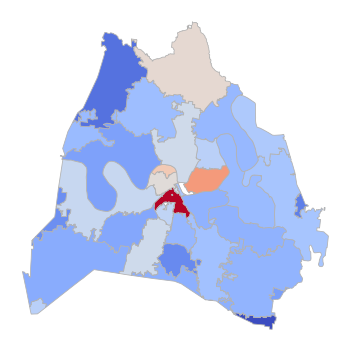

In [476]:
#Now plot the desired figure
#print(type(city_zipcodes['zip']))
zip_scores = city_zipcodes.merge(score_data, how='left', left_on='zip', right_on='zipcode')
#zip_scores['gent_perc'] = zip_scores['gentrification_score'].rank(pct=True)
#print(city_zip_counts['city'])

#then plot graph as shown below
data = zip_scores
na = data[pd.isna(data['gentrification_score'])]
#data
fig, ax = plt.subplots(1, figsize=(5,5))
ax.axis('off')
na.plot(color='white', linewidth=0.8, ax=ax, edgecolor='0.7')
data.plot(column='gentrification_score', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.7')
fig.tight_layout()
city = 'nashville'
feature = 'gent_score'
fig.savefig(city+'_'+feature+'.png', format='png', dpi=1000)
plt.show()